In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import charts_function_list
import os
import seaborn as sns

In [3]:
base,data,outputs = charts_function_list.folder_setup()

In [4]:
os.chdir(data)
tall_football = pd.read_csv('tallest football players.csv')
tall_football = tall_football.replace({'Position':{'S':'DB',
                                  'CB':'DB'}})
tall_football = tall_football.sort_values(by=['Position','Weight'],ascending=False).drop_duplicates(subset='Position')

In [5]:
def url_pull(team_abbrev):
    url = 'http://www.nfl.com/teams/roster?d-447263-n=1&team='+team_abbrev+'&d-447263-o=2&d-447263-p=1&d-447263-'
    html = urlopen(url)
    soup = BeautifulSoup(html,"lxml")
    return soup

def frame_setup(soup):
    headers = [th.get_text() for th in soup.select('tr')[1].find_all("th")] #get header list
    headers = [x.strip('\n') for x in headers] #remove space
    rows = soup.select('tr')[2:]
    row_text = [th.get_text() for th in rows]
    row_frame = pd.DataFrame([row_text[x].split('\n')[1:] for x in range(len(row_text))],columns=headers)
    heights = [(int(x),int(y.strip("\""))) for x,y in row_frame['Height'].str.strip().str.split("'")]
    row_frame['Inches'] = [(x[0]*12)+(x[1]) for x in heights]
    return row_frame
    

In [6]:
stew = []
error_list = []
team_list = ['ari','atl','buf','car','chi','cin',
             'bal','cle','dal','den','det','pit','gb','hou','ind','jax','kc','lac','la','min',
            'mia','ne','nyg','nyj','oak','phi','sf','sea','tb','ten','was','no']


for team in team_list:
    soup = url_pull(team)
    try:
        stew.append(frame_setup(soup))
    except:
        error_list.append(team)
        
full_nfl_frame = pd.concat(stew)

In [7]:

full_nfl_frame = full_nfl_frame.replace({'Pos':{'S':'DB',
                                                   'CB':'DB',
                                                     'FS':'DB',
                                                     'ILB':'LB',
                                                     'MLB':'LB',
                                                     'C':'OL',
                                                'OLB':'LB',
                                                'OT':'OL',
                                                'SS':'DB',
                                                'SAF':'DB',
                                                'OG':'OL',
                                                'NT':'DT'
                                                
                                                    }})


#remove position that don't have heights listed in the tall list
remove_list = ['FB','LS']

full_nfl_frame = full_nfl_frame[~full_nfl_frame['Pos'].isin(remove_list)].copy()



In [10]:
#compare positions
current_position = set(full_nfl_frame['Pos'].unique())
tall_list = set(tall_football['Position'].unique())
print('Mismatch btw Tall List and Current Players: '+str(list(tall_list - current_position)))
print('Current Players and Mismatch btw Tall List: '+str(list(current_position-tall_list)))

Mismatch btw Tall List and Current Players: []
Current Players and Mismatch btw Tall List: []


In [50]:
full_nfl_frame.pivot_table('Inches',index='Pos').sort_index().values

,Inches
Pos,
DB,71.832898
DE,76.027211
DT,74.978723
K,72.057143
LB,73.929961
OL,76.847826
P,74.029412
QB,75.292683
RB,71.000000


In [20]:
tall_football = tall_football.sort_values(by=['Height','Position'],ascending=True).reset_index(drop=True)

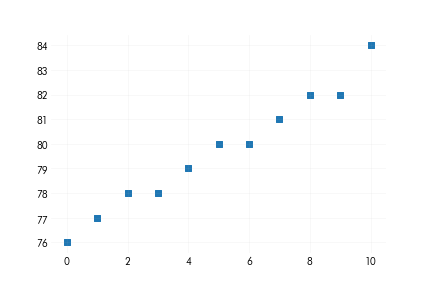

In [18]:
plt.scatter(tall_football.index,tall_football.Height,marker='s')

In [23]:
sort_order = {k:v for k,v in zip(tall_football['Position'].values,tall_football.index.values)}
full_nfl_frame['Sort_Order'] = full_nfl_frame['Pos'].map(sort_order)
full_nfl_frame  = full_nfl_frame.sort_values(by=['Sort_Order','Inches']).reset_index(drop=True)

In [28]:
full_nfl_frame  = full_nfl_frame.sort_values(by=['Sort_Order','Inches']).reset_index(drop=True)

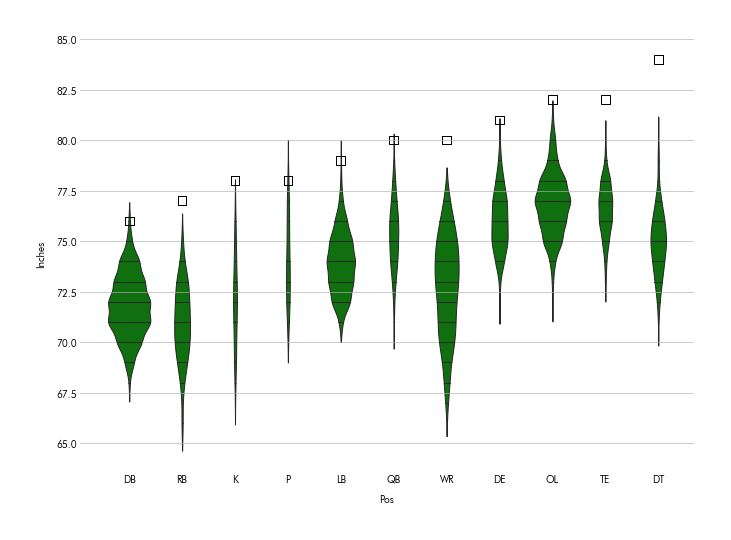

In [55]:
fig, ax = plt.subplots(figsize=(11,8))
ax.grid(alpha=.8)
sns.violinplot(x='Pos',y='Inches',data=full_nfl_frame,color='green',inner='stick',linewidth=1,scale='count')
plt.scatter(tall_football.index,tall_football.Height,marker='s',facecolor='',edgecolor='black',s=75)

In [40]:
full_nfl_frame[full_nfl_frame['Pos']=='P']

,No,Name,Pos,Status,Height,Weight,Birthdate,Exp,College,Inches,Sort_Order
561,7,"Carter, Cory",P,RES,"5'11""",220,3/5/1994,1,Texas Southern,71,3
562,5,"Palardy, Michael",P,ACT,"5'11""",200,7/6/1992,3,Tennessee,71,3
563,1,"Johnston, Cameron",P,ACT,"5'11""",194,2/24/1992,1,Ohio State,71,3
564,5,"Bosher, Matt",P,ACT,"6'0""",208,10/18/1987,8,Miami (Fla.),72,3
565,9,"Bojorquez, Corey",P,ACT,"6'0""",208,9/13/1996,0,New Mexico,72,3
566,6,"Jones, Chris",P,ACT,"6'0""",205,7/21/1989,7,Carson-Newman,72,3
567,1,"King, Marquette",P,ACT,"6'0""",195,10/26/1988,7,Fort Valley State,72,3
568,2,"Sanchez, Rigoberto",P,ACT,"6'0""",195,9/8/1994,2,Hawaii,72,3
569,2,"Haack, Matt",P,ACT,"6'0""",202,7/25/1994,2,Arizona State,72,3
570,2,"Lee, Andy",P,ACT,"6'1""",185,8/11/1982,15,Pittsburgh,73,3


In [39]:
tall_football

,Position,Player,Side,Ft,Inches,Height,Weight,"Sources: https://thatonesportsshow.com, http://www.nfl.com/draft/2017/profiles, justsportsstats.com"
0,DB,George Iloka,D,6,4,76,225,NaN
1,RB,Bert Coan,O,6,5,77,220,NaN
2,K,"Cornelius Joseph Dennis ""Neil"" O’Donoghue",S/T,6,6,78,208,NaN
3,P,Pat McInally,S/T,6,6,78,210,NaN
4,LB,"Ted ""The Mad Stork"" Hendricks",D,6,7,79,220,NaN
5,QB,Dan McGwire,O,6,8,80,240,NaN
6,WR,Harold Carmichael,O,6,8,80,225,NaN
7,DE,Too Tall Jones,D,6,9,81,270,NaN
8,OL,Dan Skipper,O,6,10,82,309,NaN
9,TE,Morris Stroud,O,6,10,82,255,NaN
